In [6]:
import csv
import os.path
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from rbflayer import RBFLayer, InitCentersRandom
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import math
import pandas as pd

In [11]:
# loading of dataset 
dataset = []
labels = []

def load_dataset(is_normalize=True, is_remove_outlier=True, select_top=20):
    global dataset, labels
    with open('OnlineNewsPopularity.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        header = next(reader) # the first row
        header = header[1:-1]
        header = [x.strip(' ') for x in header]
        
        temp_data = []
        temp_label = []

        for idx, row in enumerate(reader):            
            slice_row = row[1:-1]
            temp_data.append(slice_row)
            temp_label.append(row[-1])
        
        # convert elements to float        
        for idx, row in enumerate(temp_data):        
            dataset.append([float(i) for i in row[:]])
        for idx, row in enumerate(temp_label):
            labels.append(float(row))                
    
        if is_normalize:
            # it is important which type of normalization method you use
            scaler = preprocessing.StandardScaler()
            dataset = scaler.fit_transform(dataset)
            # last item uses MinMaxScaler
            labels = np.array(labels).reshape(-1, 1)
            scaler = preprocessing.RobustScaler()
            labels = scaler.fit_transform(labels)
            print('Data is normalize')
        else:
            print('No normalize apply')        
            
        if is_remove_outlier:
            dataset, labels = reject_outliers(dataset, labels)    
            
        if 0 < select_top < len(dataset):            
            top_features = pca_important_features(dataset, header, top=select_top)
            feature_keys = [f[1] for f in top_features]
            df = pd.DataFrame(dataset, columns=header)
            top_dataset = []
            for name in feature_keys:
#                 name = ' {0}'.format(name)
                top_dataset.append(df.loc[:, name])
            dataset = np.transpose(top_dataset)
            
    return np.array(dataset), np.array(labels).reshape(-1, 1)

def pca_important_features(dataset, header, top=10):
    scaleFeatures = True
    pca = PCA(n_components=5, svd_solver='full')
    pca.fit(dataset)
    T = pca.transform(dataset)
    top_features = extract_features(T, pca.components_, header, top)
    return top_features
    
def extract_features(transformed_features, components_, columns, top):
    num_columns = len(columns)

    # This funtion will project your *original* feature (columns)
    # onto your principal component feature-space, so that you can
    # visualize how "important" each one was in the
    # multi-dimensional scaling

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    ## visualize projections

    # Sort each column by it's length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print("Features by top {0} importance:".format(top))
    for feature in important_features[:top]:
        print(feature)
    print()
    return important_features[:top]
        
def reject_outliers(dataset, labels, m=40):        
    """
    Higher the value 'm' more outliers
    """
    d = np.abs(labels - np.median(labels))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
        
    # remove outliers in dataset and labels
    sub_dataset = []
    sub_labels = []
    outlier_labels = []
    for idx, item in enumerate(s):        
        if item < m:
            sub_labels.append(labels[idx])
            sub_dataset.append(dataset[idx])        
        else:
            outlier_labels.append(labels[idx])
    print('Outlier removed: {0}'.format(len(outlier_labels)))
    return sub_dataset, sub_labels

In [18]:
# Splitting of dataset into train and test
# Dataset if normalize using MinMaxScaler
dataset = []
labels = []
dataset, labels = load_dataset(is_normalize=True, is_remove_outlier=True, select_top=20)
print('Dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))

x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, shuffle=False, random_state=42)
print("x_train: {0}, y_train: {1}".format(x_train.shape, y_train.shape))
print("x_test: {0}, y_test: {1}".format(x_test.shape, y_test.shape))

# print(dataset[1])
# print(labels[:-10])

Data is normalize
Outlier removed: 554
Features by top 20 importance:
(6.827813863641121, 'min_negative_polarity')
(6.595119455530813, 'rate_negative_words')
(6.387680338480462, 'global_rate_negative_words')
(6.372956031560736, 'avg_negative_polarity')
(5.3943035307350415, 'global_sentiment_polarity')
(5.227351857914837, 'kw_avg_avg')
(5.166828898533202, 'kw_avg_max')
(5.1514040003044785, 'rate_positive_words')
(4.783510898063484, 'kw_max_max')
(4.623461109529173, 'timedelta')
(4.456103155589684, 'kw_min_min')
(4.449077298210287, 'LDA_04')
(4.433812293574422, 'global_subjectivity')
(4.3830556497589495, 'LDA_03')
(4.043766881660036, 'avg_positive_polarity')
(4.008090031950794, 'max_positive_polarity')
(3.9487548298223185, 'data_channel_is_tech')
(3.5201417859416653, 'kw_max_avg')
(3.458114995892193, 'global_rate_positive_words')
(3.337617397325415, 'kw_min_avg')

Dataset shape: (39090, 20), Labels: (39090, 1)
x_train: (31272, 20), y_train: (31272, 1)
x_test: (7818, 20), y_test: (7818, 1

dataset (39090, 20)
labels (39090, 1)
Labels max value: 12.891046386192018
Labels min value: -0.7545846817691478
Labels avg value: 0.6366970476948198


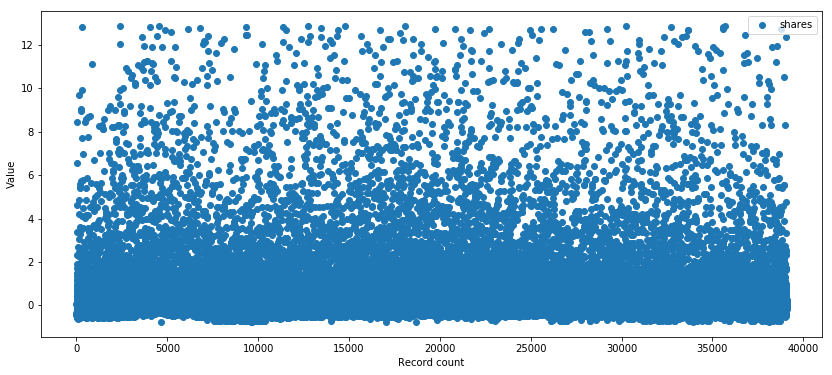

In [19]:
# Quick view of processed datasets
print('dataset {0}'.format(dataset.shape))
print('labels {0}'.format(labels.shape))
print('Labels max value: {0}'.format(np.max(labels)))
print('Labels min value: {0}'.format(np.min(labels)))
print('Labels avg value: {0}'.format(np.average(labels)))

def show_graph(data):
    plt.figure(figsize=(14,6))
    plt.xlabel("Record count")
    plt.ylabel("Value")
    plt.title("")
    x = list(range(len(data)))
    plt.scatter(x, [pt[0] for pt in data], label='shares')
    plt.legend(loc='upper right')
    plt.show()

def show_histogram(data):
    plt.figure(figsize=(14,6))
    plt.hist(data, 100)
    plt.show()

show_graph(labels)
# show_histogram(labels)

In [20]:
# https://www.youtube.com/watch?v=1Cw45yNm6VA
# build model
# beta - controls the drop off of circle. higher the beta the faster the circle will drop off. This will then affect the 
#        size of the circle, faster drop off will cause new circle to form.
#        (Drop of refers of gradient of circle, how smooth transit from circle area to non-circle area)
# training with callbacks
model = Sequential()
rbflayer = RBFLayer(20,
                    initializer=InitCentersRandom(x_train), 
                    betas=1.5,
                    input_shape=(20,))
model.add(rbflayer)
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer=RMSprop(lr=0.001),
              metrics=['mse'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rbf_layer_3 (RBFLayer)       (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 441
Trainable params: 441
Non-trainable params: 0
_________________________________________________________________


In [21]:
# training with callbacks
saved_weights_name = 'best_weights_rbf.h5'

# load weights if any
if os.path.isfile(saved_weights_name):
    model.load_weights(saved_weights_name)
    print("Weights loaded: {0}".format(saved_weights_name))

early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.0001,
                           patience=10,
                           mode='min',
                           verbose=1)

checkpoint = ModelCheckpoint(saved_weights_name,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             period=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=4,
                              min_lr=0.00001,
                              verbose=1)
    
# history = model.fit(x_train, y_train,
#           epochs=50,
#           validation_data=(x_test, y_test),
#           callbacks=[early_stop, checkpoint, reduce_lr],
#           verbose=1)

Train on 31272 samples, validate on 7818 samples
Epoch 1/50
31272/31272 [==============================] - 3s 87us/step - loss: 3.2439 - mean_squared_error: 3.2439 - val_loss: 2.6597 - val_mean_squared_error: 2.6597

Epoch 00001: val_loss improved from inf to 2.65973, saving model to best_weights_rbf.h5
Epoch 2/50
31272/31272 [==============================] - 3s 91us/step - loss: 3.2322 - mean_squared_error: 3.2322 - val_loss: 2.6686 - val_mean_squared_error: 2.6686

Epoch 00002: val_loss did not improve
Epoch 3/50
31272/31272 [==============================] - 3s 84us/step - loss: 3.2287 - mean_squared_error: 3.2287 - val_loss: 2.6710 - val_mean_squared_error: 2.6710

Epoch 00003: val_loss did not improve
Epoch 4/50
31272/31272 [==============================] - 3s 86us/step - loss: 3.2193 - mean_squared_error: 3.2193 - val_loss: 2.6347 - val_mean_squared_error: 2.6347

Epoch 00004: val_loss improved from 2.65973 to 2.63473, saving model to best_weights_rbf.h5
Epoch 5/50
31272/31272 

31272/31272 [==============================] - 3s 97us/step - loss: 3.1058 - mean_squared_error: 3.1058 - val_loss: 2.5352 - val_mean_squared_error: 2.5352

Epoch 00037: val_loss did not improve
Epoch 38/50
31272/31272 [==============================] - 3s 97us/step - loss: 3.1054 - mean_squared_error: 3.1054 - val_loss: 2.5317 - val_mean_squared_error: 2.5317

Epoch 00038: val_loss did not improve
Epoch 39/50
31272/31272 [==============================] - 3s 95us/step - loss: 3.1053 - mean_squared_error: 3.1053 - val_loss: 2.5313 - val_mean_squared_error: 2.5313

Epoch 00039: val_loss did not improve
Epoch 40/50
31272/31272 [==============================] - 3s 95us/step - loss: 3.1051 - mean_squared_error: 3.1051 - val_loss: 2.5277 - val_mean_squared_error: 2.5277

Epoch 00040: val_loss did not improve

Epoch 00040: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 41/50
31272/31272 [==============================] - 3s 95us/step - loss: 3.1045 - mean_squared_

7818/7818 [==============================] - 0s 25us/step
actual max 12.891046386192018
actual min -0.7524271844660194
actual median -0.05393743257820928
predict max 0.970328152179718
predict min 0.10615601390600204
predict median 0.6084823608398438

loss: 2.554835
mean_squared_error: 2.554835
root_mse: 1.598385
explained_variance_score: -63.611789
mean_absolute_error: 0.958138
mean_squared_log_error: 0.496449
median_absolute_error: 0.702792
r2_score: -63.816223


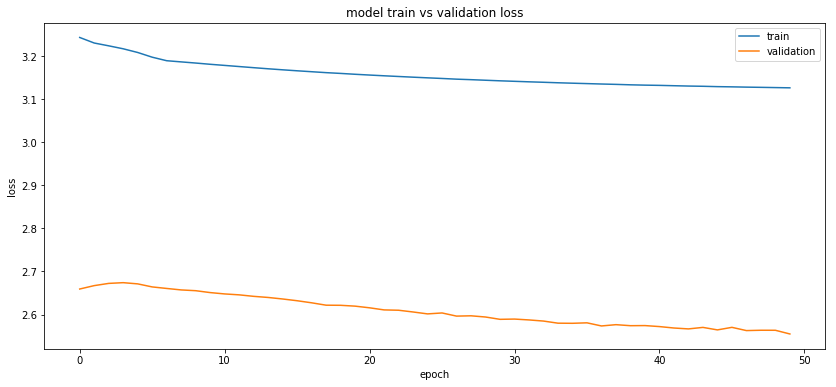

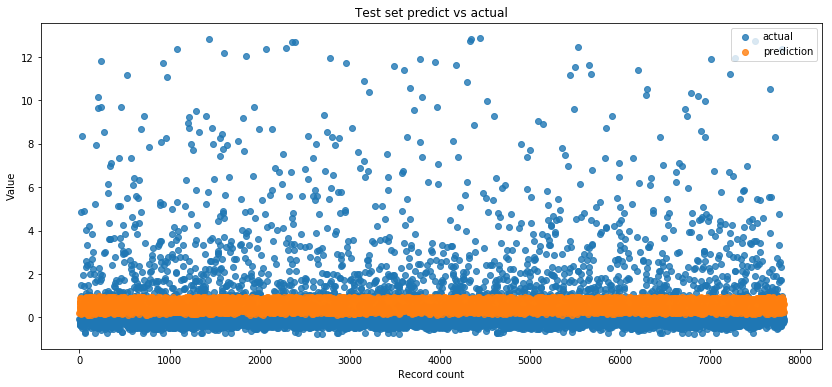

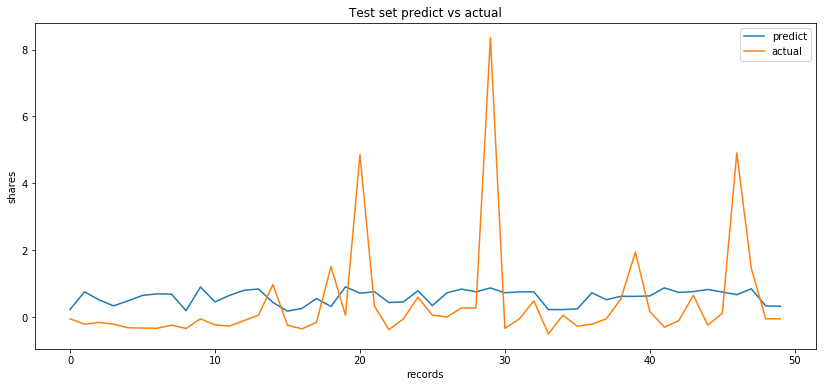

In [17]:
# showing results
scores = model.evaluate(x_test, y_test)

# http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
y_pred = model.predict(x_test)

root_mse = math.sqrt(scores[1])
var_score = explained_variance_score(y_pred, y_test)
mean_abs_error = mean_absolute_error(y_pred, y_test)
mean_sqare_log_error = mean_squared_log_error(y_pred, y_test)
median_abs_error = median_absolute_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

print('actual max {0}'.format(np.max(y_test)))
print('actual min {0}'.format(np.min(y_test)))
print('actual median {0}'.format(np.median(y_test)))
print('predict max {0}'.format(np.max(y_pred)))
print('predict min {0}'.format(np.min(y_pred)))
print('predict median {0}'.format(np.median(y_pred)))
print()
print("{0}: {1}".format(model.metrics_names[0], round(scores[0], 6)))
print("{0}: {1}".format(model.metrics_names[1], round(scores[1], 6)))
print('root_mse: {0}'.format(round(root_mse, 6)))
print('explained_variance_score: {0}'.format(round(var_score, 6)))
print('mean_absolute_error: {0}'.format(round(mean_abs_error, 6)))
print('mean_squared_log_error: {0}'.format(round(mean_sqare_log_error, 6)))
print('median_absolute_error: {0}'.format(round(median_abs_error, 6)))
print('r2_score: {0}'.format(round(r2, 6)))

# plt.figure(figsize=(14,6))
# plt.hist(y_pred, 100)
# plt.hist(y_test, 100)
# plt.show()

plt.figure(figsize=(14,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.figure(figsize=(14,6))
plt.xlabel("Record count")
plt.ylabel("Value")
plt.title("Test set predict vs actual")
x = list(range(len(y_pred)))
# plt.ylim(0, 1)
plt.scatter(x, [pt[0] for pt in y_test], label='actual', alpha=0.8)
plt.scatter(x, [pt[0] for pt in y_pred], label='prediction', alpha=0.8)
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(14,6))
plt.title('Test set predict vs actual')
plt.plot(y_pred[:50])
plt.plot(y_test[:50])
plt.ylabel('shares')
plt.xlabel('records')
plt.legend(['predict', 'actual'], loc='upper right', borderaxespad=0.5)
plt.show()